# Change Points detection on time series data 

In [117]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

## Getting data using pandas

## make sure the DGS10.csv, alcohol-sales.csv, daily-min-temperature.csv files in current working directory check the path while running the pd.read_csv() 

In [119]:
df = pd.read_csv('/content/DGS10.csv',  parse_dates=['DATE'], index_col='DATE')
df.head() 



,DGS10
DATE,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


In [124]:
df2 = pd.read_csv('/content/daily-min-temperatures.csv', parse_dates=['Date'], index_col='Date')
df2.head() 

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


## Renaming columns for convinence

In [122]:
def get_col_names(df): 
  cols =  df.columns 
  return list(cols)

def columns_rename(df): 
  return df.rename(columns = {get_col_names(df)[0] : 'dat_values'}, inplace= True) 



In [123]:
columns_rename(df) 
df.head() 

,dat_values
DATE,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


In [125]:
columns_rename(df2) 
df2.head() 

,dat_values
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [126]:
print(df.shape) 
print(df2.shape) 

(15445, 1)
(3650, 1)


## checking unnecessary values in columns and removing it 

In [127]:
df['dat_values'].unique() 

array(['4.06', '4.03', '3.99', ..., '1.29', '1.34', '1.42'], dtype=object)

In [128]:
check = df.dat_values

In [129]:
df.drop(df.index[df['dat_values'] == '.'], inplace = True)

In [130]:
df.head()

,dat_values
DATE,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


In [131]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df.dat_values, mode='lines', name='dat_values'))

fig.update_layout(showlegend=True)
fig.show() 

## plotting the Temperature time series Data 

In [132]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df2.index, y=df2.dat_values, mode='lines', name='dat_values'))

fig.update_layout(showlegend=True)
fig.show() 

## seperating the data into test part and train part to train our model 

In [133]:
train_size = int(len(df) * 0.96)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(14192, 1) (592, 1)


In [143]:
train_size_2 = int(len(df2) * 0.95)
test_size_2 = len(df2) - train_size_2
train_2, test_2 = df2.iloc[0:train_size_2], df2.iloc[train_size_2:len(df)]
print(train_2.shape, test_2.shape)

(3467, 1) (183, 1)


# Scaling the data using sklearn StandardScaler

In [144]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaler = scaler.fit(train[['dat_values']])
train['dat_values'] = scaler.transform(train[['dat_values']])
test['dat_values'] = scaler.transform(test[['dat_values']])

In [146]:
scaler = scaler.fit(train_2[['dat_values']])
train_2['dat_values'] = scaler.transform(train_2[['dat_values']])
test_2['dat_values'] = scaler.transform(test_2[['dat_values']])

## creating the data using the time steps to train the lstm model

In [148]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [149]:
TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
  train[['dat_values']],
  train.dat_values,
  TIME_STEPS
)
X_test, y_test = create_dataset(
  test[['dat_values']],
  test.dat_values,
  TIME_STEPS
)
print(X_train.shape)

(14162, 30, 1)


In [150]:
TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
X_train_2, y_train_2 = create_dataset(
  train_2[['dat_values']],
  train_2.dat_values,
  TIME_STEPS
)
X_test_2, y_test_2 = create_dataset(
  test_2[['dat_values']],
  test_2.dat_values,
  TIME_STEPS
)
print(X_train_2.shape)

(3437, 30, 1)


## LSTM AutoEncoder neural network model for change point detection

In [151]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    128,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=128, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.LSTM(units=64, return_sequences=True))

model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)
model.compile(loss='mae', optimizer='adam')
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 64)            49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 64)           

## writing the call back and training the model 

In [152]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')


history = model.fit(
    X_train, y_train,
    epochs=100,
   batch_size=32,
   callbacks = [es], 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/100
399/399 [==============================] - 17s 31ms/step - loss: 0.1813 - val_loss: 0.0838
Epoch 2/100
399/399 [==============================] - 12s 29ms/step - loss: 0.1174 - val_loss: 0.0876
Epoch 3/100
399/399 [==============================] - 11s 29ms/step - loss: 0.1108 - val_loss: 0.0653
Epoch 4/100
399/399 [==============================] - 12s 29ms/step - loss: 0.1144 - val_loss: 0.0517
Epoch 5/100
399/399 [==============================] - 11s 29ms/step - loss: 0.1084 - val_loss: 0.0712
Epoch 6/100
399/399 [==============================] - 11s 29ms/step - loss: 0.1042 - val_loss: 0.1119
Epoch 7/100
399/399 [==============================] - 11s 29ms/step - loss: 0.1057 - val_loss: 0.0740
Epoch 8/100
399/399 [==============================] - 11s 29ms/step - loss: 0.1024 - val_loss: 0.0729


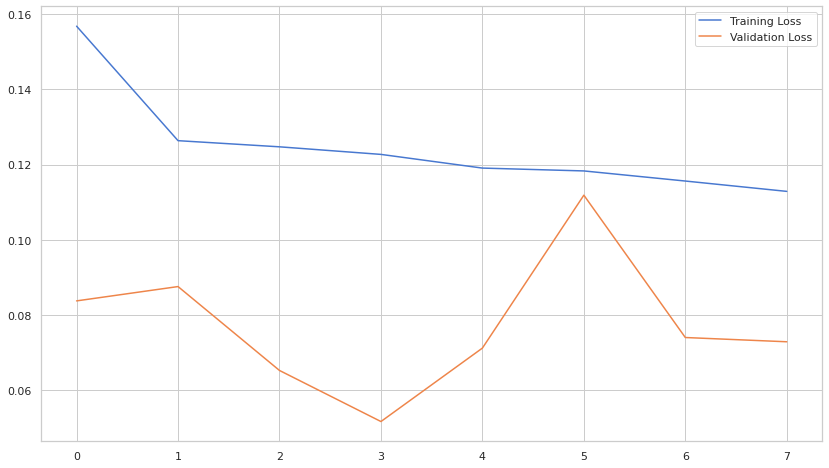

In [153]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

In [154]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

In [155]:
model.evaluate(X_test,y_test)


18/18 [==============================] - 0s 10ms/step - loss: 0.0803


0.08034098893404007

# Choosing threshold play major role in predicting change points CASE 1: 

In [184]:

threshold = 0.15

In [185]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [186]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anamoly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Temp'] = test[TIME_STEPS:].dat_values

## depending the data set we need to choose the threshold value. The values above the threshold lines are Change points 

In [187]:

import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=test[TIME_STEPS:].index,y=test_score_df.loss,mode='lines',name='Test Loss'))
fig.add_trace (go.Scatter(x=test[TIME_STEPS:].index,y=test_score_df.threshold,mode='lines',name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [188]:
anamolies = test_score_df[test_score_df.anamoly == True]
anamolies.head()

,dat_values,loss,threshold,anamoly,Temp
DATE,,,,,
2018-12-13,-1.143566,0.165781,0.15,True,-1.143566
2018-12-14,-1.150525,0.162712,0.15,True,-1.150525
2018-12-17,-1.160964,0.166414,0.15,True,-1.160964
2018-12-18,-1.174883,0.173257,0.15,True,-1.174883
2018-12-19,-1.192281,0.182560,0.15,True,-1.192281


## Plotting the change points on the data 

In [189]:


fig = go.Figure()
fig.add_trace(go.Scatter(x=test[TIME_STEPS:].index,y=scaler.inverse_transform(test[TIME_STEPS:].dat_values),mode='lines',name='Close Price'))
fig.add_trace (go.Scatter(x=anamolies.index,y=scaler.inverse_transform(anamolies.dat_values),mode='markers',name='Anomly'))
fig.update_layout(showlegend=True)
fig.show()

# Choosing Threshold for new temperature data CASE 2 

In [200]:
threshold = 1.56

In [201]:
X_train2_pred = model.predict(X_train_2)
test_mae_loss = np.mean(np.abs(X_train2_pred - X_train_2), axis=1)

In [207]:
test_score_df = pd.DataFrame(train_2[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anamoly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Temp'] = train_2[TIME_STEPS:].dat_values

In [208]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_2[TIME_STEPS:].index,y=test_score_df.loss,mode='lines',name='Test Loss'))
fig.add_trace (go.Scatter(x=train_2[TIME_STEPS:].index,y=test_score_df.threshold,mode='lines',name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [209]:
anamolies = test_score_df[test_score_df.anamoly == True]
anamolies.head()

,dat_values,loss,threshold,anamoly,Temp
Date,,,,,
1981-03-23,-0.587502,1.881986,1.56,True,-0.587502
1981-03-24,0.534808,1.637926,1.56,True,0.534808
1981-04-27,-0.319124,1.566558,1.56,True,-0.319124
1981-09-09,0.120041,1.646334,1.56,True,0.120041
1981-09-19,-0.172736,1.657398,1.56,True,-0.172736


In [214]:


fig = go.Figure()
fig.add_trace(go.Scatter(x=train_2[TIME_STEPS:].index,y=scaler.inverse_transform(train_2[TIME_STEPS:].dat_values),mode='lines',name='Temperatue'))
fig.add_trace (go.Scatter(x=anamolies.index,y=scaler.inverse_transform(anamolies.dat_values),mode='markers',name='Anomly'))
fig.update_layout(showlegend=True)
fig.show()

## choosing threshold and prediction on the Alcohol sales data 

In [217]:
alcohol_sales = pd.read_csv('/content/alcohol-sales.csv', parse_dates=['DATE'], index_col='DATE')
alcohol_sales.head() 

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-01-02,3458
1992-01-03,4002
1992-01-04,4564
1992-01-05,4221


In [219]:
columns_rename(alcohol_sales)
alcohol_sales.head() 

,dat_values
DATE,
1992-01-01,3459
1992-01-02,3458
1992-01-03,4002
1992-01-04,4564
1992-01-05,4221


In [220]:
scaler = scaler.fit(train[['dat_values']])
alcohol_sales['dat_values'] = scaler.transform(alcohol_sales[['dat_values']]) 

In [235]:
alcohol_sales.head() 

,dat_values
DATE,
1992-01-01,3459.0
1992-01-02,3458.0
1992-01-03,4002.0
1992-01-04,4564.0
1992-01-05,4221.0


In [237]:
# scaling 
from sklearn.preprocessing import MinMaxScaler 

norm = MinMaxScaler() 
alcohol_sales['dat_values'] = norm.fit_transform(alcohol_sales)
alcohol_sales.head() 

,dat_values
DATE,
1992-01-01,0.031755
1992-01-02,0.031681
1992-01-03,0.072043
1992-01-04,0.113741
1992-01-05,0.088292


In [238]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [239]:
X_alcho, y_alcho = create_dataset(
  alcohol_sales[['dat_values']],
  alcohol_sales.dat_values,
  TIME_STEPS
)

In [240]:
print(X_alcho.shape, y_alcho.shape)

(318, 30, 1) (318,)


# Threshold

In [253]:
threshold = 0.11


In [254]:
X_train2_pred = model.predict(X_alcho)
test_mae_loss = np.mean(np.abs(X_train2_pred - X_alcho), axis=1)

In [255]:
test_score_df = pd.DataFrame(alcohol_sales[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anamoly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Temp'] = alcohol_sales[TIME_STEPS:].dat_values 

In [256]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=alcohol_sales[TIME_STEPS:].index,y=test_score_df.loss,mode='lines',name='Test Loss'))
fig.add_trace (go.Scatter(x=alcohol_sales[TIME_STEPS:].index,y=test_score_df.threshold,mode='lines',name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [257]:
anamolies = test_score_df[test_score_df.anamoly == True]
anamolies.head()

,dat_values,loss,threshold,anamoly,Temp
DATE,,,,,
2003-01-01,0.170277,0.119189,0.11,True,0.170277
2004-01-01,0.192759,0.135111,0.11,True,0.192759
2005-01-01,0.187417,0.153626,0.11,True,0.187417
2005-01-07,0.320597,0.132827,0.11,True,0.320597
2006-01-01,0.225182,0.112284,0.11,True,0.225182


# Alcohal sales have less number of examples 
## plotting the change points 

In [258]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=alcohol_sales[TIME_STEPS:].index,y=scaler.inverse_transform(alcohol_sales[TIME_STEPS:].dat_values),mode='lines',name='Temperatue'))
fig.add_trace (go.Scatter(x=anamolies.index,y=scaler.inverse_transform(anamolies.dat_values),mode='markers',name='Anomly'))
fig.update_layout(showlegend=True)
fig.show()

### Finally 
####   Choose the threshold based on the data set you want to predict 